In [1]:
import tensorflow as tf
import numpy as np
import nengo_dl
import nengo
import random
import _init_paths
import matplotlib.pyplot as plt

#tf.reset_default_graph()
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


# TF Model definition

In [25]:
# input
inp = tf.keras.Input(shape=(28, 28, 1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(inp)

# Default pool_size = (2,2), padding = "valid", data_format = "channels_last".
max_pool0 = tf.keras.layers.MaxPool2D()(conv0) 

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
)(max_pool0)

# max_pool1 = tf.keras.layers.MaxPool2D()(conv1) 

# conv2 = tf.keras.layers.Conv2D(
#     filters=64,
#     kernel_size=3,
#     strides=2,
#     activation=tf.nn.relu,
# )(max_pool1)


# fully connected layer
flatten = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(units=10, activation="softmax")(flatten)

model = tf.keras.Model(inputs=inp, outputs=dense)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                23050     
Total params: 41,866
Trainable params: 41,866
Non-trainable params: 0
_______________________________________________________

## TF Model Compilation and Evaluation

In [27]:
model.compile(
  optimizer=tf.optimizers.Adam(0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=[tf.metrics.sparse_categorical_accuracy])
model.fit(train_images, train_labels, epochs=4)

Epoch 1/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2801 - sparse_categorical_accuracy: 0.9434
Epoch 2/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0725 - sparse_categorical_accuracy: 0.9784
Epoch 3/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0585 - sparse_categorical_accuracy: 0.9822
Epoch 4/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9840


In [28]:
model.evaluate(test_images, test_labels)
# [0.06594502180814743, 0.9804999828338623]

313/313 [==============================] - 0s 2ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9815


[0.06394093483686447, 0.9815000295639038]

# Check Nengo DL MaxPool

In [30]:
n_steps = 40
np.random.seed(100)
ndl_model_3 = nengo_dl.Converter(model, 
                               swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
                               scale_firing_rates=5,
                               max_to_avg_pool=False,
                               synapse=0.005)

with ndl_model_3.net:
  nengo_dl.configure_settings(stateful=False)

In [9]:
ndl_test_images = np.tile(
  test_images.reshape((test_images.shape[0], 1, -1)), (1, n_steps, 1))
ndl_input_3 = ndl_model_3.inputs[inp]
ndl_output_3 = ndl_model_3.outputs[dense]

In [10]:
with nengo_dl.Simulator(
  ndl_model_3.net, minibatch_size=100) as sim:
  data3 = sim.predict({ndl_input_3: ndl_test_images[:200]})

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [11]:
acc = 0
for pred, true in zip(data3[ndl_output_3][:, -1, :], test_labels):
  if np.argmax(pred) == true:
    acc += 1
print(acc/200)

0.735


# Conversion from TF to spiking Nengo DL model with custom max to avg Node

In [12]:
n_steps = 40
np.random.seed(100)
ndl_model_4 = nengo_dl.Converter(model, 
                               swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
                               scale_firing_rates=5,
                               synapse=0.005)

with ndl_model_4.net:
  nengo_dl.configure_settings(stateful=False)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:326: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  % (error_msg + ". " if error_msg else "")


## Check connections before replacing

In [13]:
ndl_model_4.net.all_nodes, ndl_model_4.net.all_ensembles, ndl_model_4.net.all_connections

([<Node "input_1" at 0x2b83bf4512d0>,
  <Node "conv2d.0.bias" at 0x2b83bf326910>,
  <Node "conv2d.0.bias_relay" at 0x2b83bf326cd0>,
  <TensorNode "max_pooling2d" at 0x2b836f97df50>,
  <Node "conv2d_1.0.bias" at 0x2b83bf2faf10>,
  <Node "conv2d_1.0.bias_relay" at 0x2b83bf2fae50>,
  <TensorNode "dense.0" at 0x2b83bf300bd0>,
  <Node "dense.0.bias" at 0x2b83bf300410>],
 [<Ensemble "conv2d.0" at 0x2b83bf30dd50>,
  <Ensemble "conv2d_1.0" at 0x2b83bf450910>],
 [<Connection at 0x2b83bf451310 from <Node "conv2d.0.bias"> to <Node "conv2d.0.bias_relay">>,
  <Connection at 0x2b8357e14550 from <Node "conv2d.0.bias_relay"> to <Neurons of <Ensemble "conv2d.0">>>,
  <Connection at 0x2b836f9b5fd0 from <Node "input_1"> to <Neurons of <Ensemble "conv2d.0">>>,
  <Connection at 0x2b82d33a8e10 from <Neurons of <Ensemble "conv2d.0">> to <TensorNode "max_pooling2d">>,
  <Connection at 0x2b83bf2fae90 from <Node "conv2d_1.0.bias"> to <Node "conv2d_1.0.bias_relay">>,
  <Connection at 0x2b83bf2fad50 from <Node "c

In [14]:
conn_from_conv0_to_max_node0 = ndl_model_3.net.all_connections[3]
print(conn_from_conv0_to_max_node0.pre_obj, conn_from_conv0_to_max_node0.post_obj)
conn_from_max_node0_to_conv1 = ndl_model_3.net.all_connections[6]
print(conn_from_max_node0_to_conv1.pre_obj, conn_from_max_node0_to_conv1.post_obj)

<Neurons of <Ensemble "conv2d.0">> <Node "max_pooling2d.0">
<Node "max_pooling2d.0"> <Neurons of <Ensemble "conv2d_1.0">>


In [15]:
# conn_from_conv1_to_max_node1 = ndl_model_3.net.all_connections[7]
# print(conn_from_conv1_to_max_node1.pre_obj, conn_from_conv1_to_max_node1.post_obj)
# conn_from_max_node1_to_conv2 = ndl_model_3.net.all_connections[10]
# print(conn_from_max_node1_to_conv2.pre_obj, conn_from_max_node1_to_conv2.post_obj)

## Replacing the Max Node with Custom Avg Node

In [16]:
def compute_max_to_average_conv0(t, inp):
  inp = inp.reshape(26, 26, 32)
  ret = np.zeros((13, 13, 32))
  
  for chnl in range(inp.shape[2]): 
    for r in range(13):
      for c in range(13):
        ret[r, c, chnl] = np.mean(inp[r*2:r*2+2, c*2:c*2+2, chnl])
  
  return ret.flatten()
        
def compute_max_to_average_conv1(t, inp):
  inp = inp.reshape(6, 6, 64)
  ret = np.zeros((3, 3, 64))
  
  for chnl in range(inp.shape[2]):
    for r in range(3):
      for c in range(3):
        ret[r, c, chnl] = np.mean(inp[r*2:r*2+2, c*2:c*2+2, chnl])
        
  return ret.flatten()

In [17]:
with ndl_model_4.net:
  new_node0 = nengo.Node(compute_max_to_average_conv0, size_in=21632, label="Custom Node 0")  
  #new_node1 = nengo.Node(compute_max_to_average_conv1, size_in=2304, label="Custom Node 1")
  
  # Connection from Conv0 to custom new_node0
  conn_from_conv0_to_max_node0 = ndl_model_4.net.all_connections[3]
  nengo.Connection(
    conn_from_conv0_to_max_node0.pre_obj,
    new_node0,
    transform=conn_from_conv0_to_max_node0.transform,
    synapse=conn_from_conv0_to_max_node0.synapse,
    #synapse=nengo.Lowpass(0.005),
    function=conn_from_conv0_to_max_node0.function
  )
  
  # Connection from new_node0 to Conv1
  conn_from_max_node0_to_conv1 = ndl_model_4.net.all_connections[6]
  nengo.Connection(
    new_node0,
    conn_from_max_node0_to_conv1.post_obj,
    transform=conn_from_max_node0_to_conv1.transform,
    #synapse=conn_from_max_node0_to_conv1.synapse,
    synapse=nengo.Lowpass(0.005),
    function=conn_from_max_node0_to_conv1.function
  )
  
  #################################################
  
#   # Connection from Conv1 to custom new_node1
#   conn_from_conv1_to_max_node1 = ndl_model_3.net.all_connections[7]
#   nengo.Connection(
#     conn_from_conv1_to_max_node1.pre_obj,
#     new_node1,
#     transform=conn_from_conv1_to_max_node1.transform,
#     synapse=conn_from_conv1_to_max_node1.synapse,
#     function=conn_from_conv1_to_max_node1.function
#     )
  
#   # Connection from custom new_node1 to Conv2.
#   conn_from_max_node1_to_conv2 = ndl_model_3.net.all_connections[10]
#   nengo.Connection(
#     new_node1,
#     conn_from_max_node1_to_conv2.post_obj,
#     transform=conn_from_max_node1_to_conv2.transform,
#     synapse=conn_from_max_node1_to_conv2.synapse,
#     function=conn_from_max_node1_to_conv2.function
#   )
  
  # Delete old connections.
  ndl_model_4.net._connections.remove(conn_from_conv0_to_max_node0)
  ndl_model_4.net._connections.remove(conn_from_max_node0_to_conv1)
  
  #ndl_model_3.net._connections.remove(conn_from_conv1_to_max_node1)
  #ndl_model_3.net._connections.remove(conn_from_max_node1_to_conv2)
  
  # Delete the two TensorNodes.
  ndl_model_4.net._nodes.remove(conn_from_conv0_to_max_node0.post_obj)
  #ndl_model_3.net._nodes.remove(conn_from_conv1_to_max_node1.post_obj)

# Check if connection was successful

In [18]:
ndl_model_4.net.all_connections, ndl_model_4.net._nodes

([<Connection at 0x2b83bf451310 from <Node "conv2d.0.bias"> to <Node "conv2d.0.bias_relay">>,
  <Connection at 0x2b8357e14550 from <Node "conv2d.0.bias_relay"> to <Neurons of <Ensemble "conv2d.0">>>,
  <Connection at 0x2b836f9b5fd0 from <Node "input_1"> to <Neurons of <Ensemble "conv2d.0">>>,
  <Connection at 0x2b83bf2fae90 from <Node "conv2d_1.0.bias"> to <Node "conv2d_1.0.bias_relay">>,
  <Connection at 0x2b83bf2fad50 from <Node "conv2d_1.0.bias_relay"> to <Neurons of <Ensemble "conv2d_1.0">>>,
  <Connection at 0x2b83bf300e10 from <Node "dense.0.bias"> to <TensorNode "dense.0">>,
  <Connection at 0x2b83bf300e90 from <Neurons of <Ensemble "conv2d_1.0">> to <TensorNode "dense.0">>,
  <Connection at 0x2b83bf2faed0 from <Neurons of <Ensemble "conv2d.0">> to <Node "Custom Node 0">>,
  <Connection at 0x2b83bf30d110 from <Node "Custom Node 0"> to <Neurons of <Ensemble "conv2d_1.0">>>],
 [<Node "input_1" at 0x2b83bf4512d0>,
  <Node "conv2d.0.bias" at 0x2b83bf326910>,
  <Node "conv2d.0.bias_r

In [19]:
ndl_test_images = np.tile(
  test_images.reshape((test_images.shape[0], 1, -1)), (1, n_steps, 1))
ndl_input_4 = ndl_model_4.inputs[inp]
ndl_output_4 = ndl_model_4.outputs[dense]

In [20]:
with nengo_dl.Simulator(
  ndl_model_4.net, minibatch_size=100) as sim:
  data4 = sim.predict({ndl_input_4: ndl_test_images[:200]})

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [21]:
acc = 0
for pred, true in zip(data4[ndl_output_4][:, -1, :], test_labels):
  if np.argmax(pred) == true:
    acc += 1
print(acc/200)

0.735


# ################################################################

In [32]:
ndl_model_3.net.all_ensembles

[<Ensemble "conv2d_2.0" at 0x2b835abcdc90>,
 <Ensemble "conv2d_3.0" at 0x2b835abddc10>]

In [33]:
ndl_model_3.net.ensembles

[<Ensemble "conv2d_2.0" at 0x2b835abcdc90>,
 <Ensemble "conv2d_3.0" at 0x2b835abddc10>]

In [47]:
ndl_model_3.net.ensembles[0].neurons.reshape(26, 26, 32)

AttributeError: 'Neurons' object has no attribute 'reshape'

In [50]:
dir(ndl_model_3.net.ensembles[0].neurons[1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_slice_string',
 'copy',
 'obj',
 'size_in',
 'size_out',
 'slice']

In [60]:
ndl_model_3.net.ensembles[0].neurons[2:100]

AttributeError: 'ObjView' object has no attribute 'reshape'

In [2]:
k = np.zeros((3, 4, 4))
k

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [3]:
for i in range(3):
  for j in range(4):
    for m in range(4):
      k[i, j, m] = 16*i+4*j+m

In [4]:
print(k)

[[[ 0.  1.  2.  3.]
  [ 4.  5.  6.  7.]
  [ 8.  9. 10. 11.]
  [12. 13. 14. 15.]]

 [[16. 17. 18. 19.]
  [20. 21. 22. 23.]
  [24. 25. 26. 27.]
  [28. 29. 30. 31.]]

 [[32. 33. 34. 35.]
  [36. 37. 38. 39.]
  [40. 41. 42. 43.]
  [44. 45. 46. 47.]]]


In [5]:
k.flatten()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.])

In [12]:
from utils.base_utils.exp_utils import get_grouped_slices_2d_pooling

In [7]:
slices = get_grouped_slices_2d_pooling(pool_size=(2, 2), rows=4, cols=4, num_chnls=3)

In [8]:
slices

array([ 0,  1,  4,  5,  2,  3,  6,  7,  8,  9, 12, 13, 10, 11, 14, 15, 16,
       17, 20, 21, 18, 19, 22, 23, 24, 25, 28, 29, 26, 27, 30, 31, 32, 33,
       36, 37, 34, 35, 38, 39, 40, 41, 44, 45, 42, 43, 46, 47])

In [9]:
matrix = np.arange(4 * 4 * 3).reshape((3, 4, 4))

In [10]:
matrix.shape

(3, 4, 4)

In [11]:
matrix[0, :, :]

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

# ###########################

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

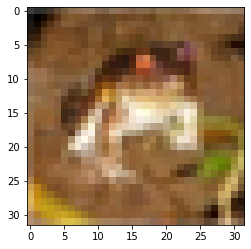

In [3]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0])

In [4]:
train_images.shape

(50000, 32, 32, 3)

In [5]:
train_images = np.moveaxis(train_images, 3, 1)
train_images.shape

(50000, 3, 32, 32)

In [6]:
flat = train_images[0].flatten()
flat.shape

(3072,)

In [9]:
for chnl in range(3):
  for row in range(32):
    print(train_images[0][chnl, row, :])
  print("*"*80)

[ 59  43  50  68  98 119 139 145 149 149 131 125 142 144 137 129 137 134
 124 139 139 133 136 139 152 163 168 159 158 158 152 148]
[ 16   0  18  51  88 120 128 127 126 116 106 101 105 113 109 112 119 109
 105 125 127 122 131 124 121 131 132 133 133 123 119 122]
[ 25  16  49  83 110 129 130 121 113 112 112 106 105 128 124 130 127 122
 115 120 130 131 139 127 126 127 130 142 130 118 120 109]
[ 33  38  87 106 115 117 114 105 107 121 125 109 113 146 133 127 118 117
 127 122 132 137 136 131 124 130 132 135 130 125 121  94]
[ 50  59 102 127 124 121 120 114 107 125 129 106 108 124 121 108  98 110
 117 120 134 140 131 141 135 127 121 119 103  87  75  67]
[ 71  84 110 129 136 131 129 119 108 122 123 105 107 111 108  98  94  97
  83  88 102  97  88 118 140 136 120 107  88  67  35  32]
[ 97 111 123 130 136 132 122 121 127 138 124 120 107  80  68  74 101 105
  65  58  63  78 136 122 139 151 129 108  95  96  89  66]
[115 119 130 140 133 127 138 137 131 133 134 108  72  51  41  72 181 209
 125  68  

In [11]:
print(flat[:200])

[ 59  43  50  68  98 119 139 145 149 149 131 125 142 144 137 129 137 134
 124 139 139 133 136 139 152 163 168 159 158 158 152 148  16   0  18  51
  88 120 128 127 126 116 106 101 105 113 109 112 119 109 105 125 127 122
 131 124 121 131 132 133 133 123 119 122  25  16  49  83 110 129 130 121
 113 112 112 106 105 128 124 130 127 122 115 120 130 131 139 127 126 127
 130 142 130 118 120 109  33  38  87 106 115 117 114 105 107 121 125 109
 113 146 133 127 118 117 127 122 132 137 136 131 124 130 132 135 130 125
 121  94  50  59 102 127 124 121 120 114 107 125 129 106 108 124 121 108
  98 110 117 120 134 140 131 141 135 127 121 119 103  87  75  67  71  84
 110 129 136 131 129 119 108 122 123 105 107 111 108  98  94  97  83  88
 102  97  88 118 140 136 120 107  88  67  35  32  97 111 123 130 136 132
 122 121]


In [13]:
slices = get_grouped_slices_2d_pooling(pool_size=(2, 2), rows=32, cols=32, num_chnls=3)

In [17]:
flat[slices][:200]

array([ 59,  43,  16,   0,  50,  68,  18,  51,  98, 119,  88, 120, 139,
       145, 128, 127, 149, 149, 126, 116, 131, 125, 106, 101, 142, 144,
       105, 113, 137, 129, 109, 112, 137, 134, 119, 109, 124, 139, 105,
       125, 139, 133, 127, 122, 136, 139, 131, 124, 152, 163, 121, 131,
       168, 159, 132, 133, 158, 158, 133, 123, 152, 148, 119, 122,  25,
        16,  33,  38,  49,  83,  87, 106, 110, 129, 115, 117, 130, 121,
       114, 105, 113, 112, 107, 121, 112, 106, 125, 109, 105, 128, 113,
       146, 124, 130, 133, 127, 127, 122, 118, 117, 115, 120, 127, 122,
       130, 131, 132, 137, 139, 127, 136, 131, 126, 127, 124, 130, 130,
       142, 132, 135, 130, 118, 130, 125, 120, 109, 121,  94,  50,  59,
        71,  84, 102, 127, 110, 129, 124, 121, 136, 131, 120, 114, 129,
       119, 107, 125, 108, 122, 129, 106, 123, 105, 108, 124, 107, 111,
       121, 108, 108,  98,  98, 110,  94,  97, 117, 120,  83,  88, 134,
       140, 102,  97, 131, 141,  88, 118, 135, 127, 140, 136, 12

In [19]:
with nengo.Network() as net:
  net.input = nengo.Node(size_in=4)

In [20]:
net.input[0]

<Node (unlabeled) at 0x2b66fe3dcc50>[0:1]

In [21]:
net.input[1]

<Node (unlabeled) at 0x2b66fe3dcc50>[1:2]

In [3]:
from utils.nengo_dl_utils import get_network_for_2x2_max_pooling

In [5]:
def get_x1(t):
  if int(t*1000.0)%7==0:
    return 10
  else:
    return 0

def get_x2(t):
  if int(t*1000.0)%10==0:
    return 10
  else:
    return 0

def get_x3(t):
  if int(t*1000.0)%12==0:
    return 10
  else:
    return 0

def get_x4(t):
  if int(t*1000.0)%5==0:
    return 10
  else:
    return 0
  
def get_xall(t):
  t = int(t*1000.0)
  ret = [10 if t%7==0 else 0, 10 if t%10==0 else 0, 10 if t%12==0 else 0, 10 if t%5==0 else 0]
  #print(ret)
  return ret

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

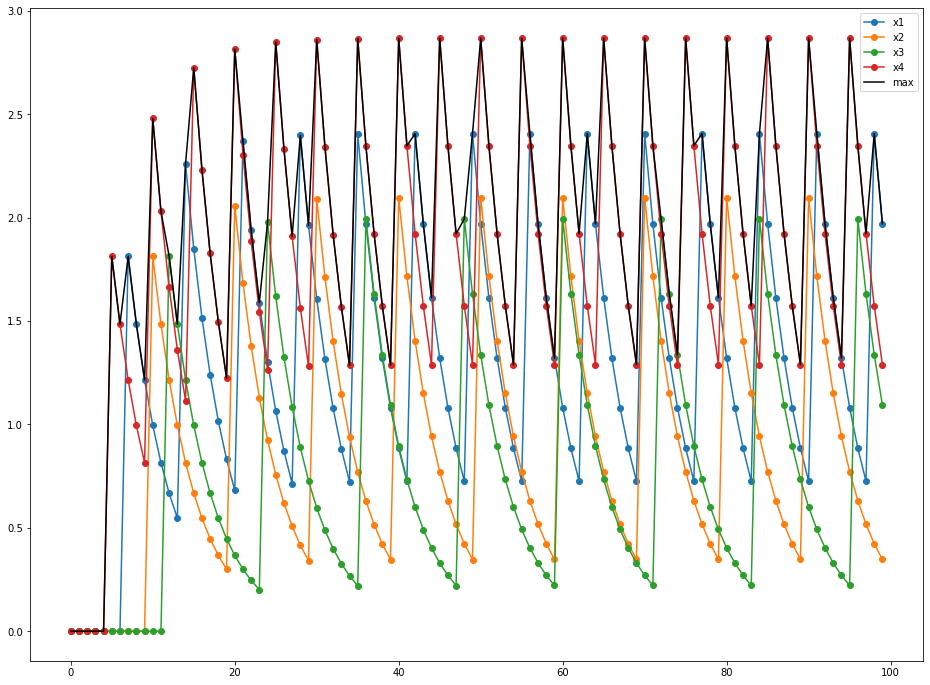

In [6]:
# See how the signals vary and stabilize after some time.
with nengo.Network(seed=90) as net:
  n1 = nengo.Node(get_x1)
  n2 = nengo.Node(get_x2)
  n3 = nengo.Node(get_x3)
  n4 = nengo.Node(get_x4)
  max_node = nengo.Node(lambda t, x: np.max(x), size_in=4)
  
  o1, o2, o3, o4 = nengo.Node(size_in=1), nengo.Node(size_in=1), nengo.Node(size_in=1), nengo.Node(size_in=1)
  nengo.Connection(n1, o1)
  nengo.Connection(n2, o2)
  nengo.Connection(n3, o3)
  nengo.Connection(n4, o4)
  
  nengo.Connection(o1, max_node[0], synapse=None)
  nengo.Connection(o2, max_node[1], synapse=None)
  nengo.Connection(o3, max_node[2], synapse=None)
  nengo.Connection(o4, max_node[3], synapse=None)
  
  mp = nengo.Probe(max_node)
  p1, p2, p3, p4 = nengo.Probe(o1), nengo.Probe(o2), nengo.Probe(o3), nengo.Probe(o4)
  
with nengo.Simulator(net) as sim:
  sim.run(0.100)

plt.figure(figsize=(16, 12))
plt.plot(sim.data[p1], label="x1", marker="o")
plt.plot(sim.data[p2], label="x2", marker="o")
plt.plot(sim.data[p3], label="x3", marker="o")
plt.plot(sim.data[p4], label="x4", marker="o")
plt.plot(sim.data[mp], label="max", color="black")
plt.legend()

In [33]:
with nengo.Network(seed=90) as net:
  max_net = get_network_for_2x2_max_pooling(radius=2, sf=1.2, do_max=True, synapse=0.001)
  #inp_node = nengo.Node([x1, x2, x3, x4])
  #inp_node = nengo.Node(get_xall)
  n1 = nengo.Node(get_x1)
  n2 = nengo.Node(get_x2)
  n3 = nengo.Node(get_x3)
  n4 = nengo.Node(get_x4)
  
  nengo.Connection(n1, max_net.input[0], synapse=0.005)
  nengo.Connection(n2, max_net.input[1], synapse=0.005)
  nengo.Connection(n3, max_net.input[2], synapse=0.005)
  nengo.Connection(n4, max_net.input[3], synapse=0.005)
  
  #nengo.Connection(inp_node, max_net.input, synapse=0.005)
  otp_probe = nengo.Probe(max_net.output, synapse=0.005)

In [34]:
with nengo.Simulator(net) as sim:
  sim.run(0.100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

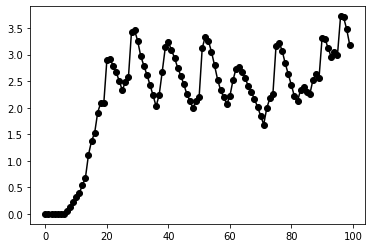

In [36]:
import matplotlib.pyplot as plt
plt.plot(sim.data[otp_probe], marker="o", color="black")